In [773]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import time

In [2]:
market_cap = pd.read_excel('Group_G copy.xlsx', sheet_name=1)
price_index = pd.read_excel('Group_G copy.xlsx', sheet_name=2, index_col='Date')
revenue = pd.read_excel('Group_G copy.xlsx', sheet_name=3)
emission = pd.read_excel('Group_G copy.xlsx', sheet_name=4)
price_index

,CAMPBELL SOUP - TOT RETURN IND (~U$) (#T) - CAMPBELL SOUP - TOT RETURN IND (~U$) (#T),ZOETIS A - TOT RETURN IND (~U$) (#T) - ZOETIS A - TOT RETURN IND (~U$) (#T),APARTMENT INV.& MAN.'A' - TOT RETURN IND (~U$) (#T) - APARTMENT INV.& MAN.'A' - TOT RETURN IND (~U$) (#T),WILLIAMS - TOT RETURN IND (~U$) (#T) - WILLIAMS - TOT RETURN IND (~U$) (#T),TNSC.'A' SBVTG. - TOT RETURN IND (~U$) (#T) - TNSC.'A' SBVTG. - TOT RETURN IND (~U$) (#T),BREAD FINANCIAL HOLDINGS - TOT RETURN IND (~U$) (#T) - BREAD FINANCIAL HOLDINGS - TOT RETURN IND (~U$) (#T),NASDAQ - TOT RETURN IND (~U$) (#T) - NASDAQ - TOT RETURN IND (~U$) (#T),ENERGEN DEAD - DELIST.30/11/18 - TOT RETURN IND (~U$) (#T) - ENERGEN DEAD - DELIST.30/11/18 - TOT RETURN IND (~U$) (#T),XEROX HOLDINGS - TOT RETURN IND (~U$) (#T) - XEROX HOLDINGS - TOT RETURN IND (~U$) (#T),UNIVERSAL HEALTH SVS.'B' - TOT RETURN IND (~U$) (#T) - UNIVERSAL HEALTH SVS.'B' - TOT RETURN IND (~U$) (#T),...,WSP GLOBAL - TOT RETURN IND (~U$) (#T) - WSP GLOBAL - TOT RETURN IND (~U$) (#T),CHIMERA INVESTMENT - TOT RETURN IND (~U$) (#T) - CHIMERA INVESTMENT - TOT RETURN IND (~U$) (#T),SYNOVUS FINANCIAL - TOT RETURN IND (~U$) (#T) - SYNOVUS FINANCIAL - TOT RETURN IND (~U$) (#T),FORTIS - TOT RETURN IND (~U$) (#T) - FORTIS - TOT RETURN IND (~U$) (#T),FREEHOLD ROYALTIES - TOT RETURN IND (~U$) (#T) - FREEHOLD ROYALTIES - TOT RETURN IND (~U$) (#T),CHEESECAKE FACTORY - TOT RETURN IND (~U$) (#T) - CHEESECAKE FACTORY - TOT RETURN IND (~U$) (#T),ROYAL CARIBBEAN GROUP - TOT RETURN IND (~U$) (#T) - ROYAL CARIBBEAN GROUP - TOT RETURN IND (~U$) (#T),ENTERPRISE PRDS.PTNS.LP. - TOT RETURN IND (~U$) (#T) - ENTERPRISE PRDS.PTNS.LP. - TOT RETURN IND (~U$) (#T),BIRCHCLIFF ENERGY - TOT RETURN IND (~U$) (#T) - BIRCHCLIFF ENERGY - TOT RETURN IND (~U$) (#T),SUPERIOR PLUS - TOT RETURN IND (~U$) (#T) - SUPERIOR PLUS - TOT RETURN IND (~U$) (#T)
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-01,6625.85,NaN,276.80,1874.56,153.56,NaN,NaN,4410.36,678.75,1024.69,...,NaN,NaN,4878.04,254.19,33.86,244.84,441.26,70.31,NaN,94.26
1999-01-04,6497.85,NaN,280.98,1814.45,158.25,NaN,NaN,4396.23,677.31,1041.98,...,NaN,NaN,4865.33,252.98,34.41,234.27,420.40,76.22,NaN,95.57
1999-01-05,6671.03,NaN,280.52,1795.67,154.96,NaN,NaN,4396.23,690.25,1046.91,...,NaN,NaN,4966.96,256.35,34.73,233.23,436.82,79.17,NaN,95.83
1999-01-06,6607.78,NaN,281.91,1852.02,154.55,NaN,NaN,4382.09,703.55,1045.68,...,NaN,NaN,5068.58,260.95,35.38,231.17,459.20,83.31,NaN,97.19
1999-01-07,6517.05,NaN,275.40,1852.02,153.77,NaN,NaN,4283.14,700.32,1016.05,...,NaN,NaN,4827.22,266.59,36.87,222.40,448.78,82.72,NaN,97.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,13531.69,503.29,2299.70,6271.60,768.72,364.26,1471.70,NaN,106.71,12286.12,...,2179.03,54.08,4374.88,4149.85,1465.38,1066.24,858.25,2220.63,1840.54,662.87
2022-12-27,13595.48,501.70,2236.86,6288.54,773.71,360.55,1464.50,NaN,107.37,12329.76,...,2193.17,54.96,4404.78,4176.78,1474.89,1052.60,842.91,2233.61,1852.48,667.17
2022-12-28,13474.99,496.62,2202.31,6158.66,764.53,347.95,1457.77,NaN,104.95,12164.79,...,2164.19,51.24,4379.66,4112.86,1424.19,1048.94,827.40,2203.01,1757.99,663.93


In [3]:
def assets_returns(assets, period, compounded=True):
    if not compounded:
        asset_return = (assets / assets.shift(periods=period)) - 1
    elif compounded:
        diff = assets / assets.shift(periods=period)
        asset_return = np.log(diff.astype('float'))
    return asset_return

In [4]:
simple_return = assets_returns(price_index.loc[:, price_index.columns != 'Date'], period=1, compounded=False)

In [6]:
log_return = assets_returns(price_index.loc[:, price_index.columns != 'Date'], period=1, compounded=True)

/Users/victoriawong/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [11]:
def get_moment(assetReturn, moment):
    if moment == 1:
        return pd.DataFrame(assetReturn.mean())
    elif moment == 2:
        return pd.DataFrame(assetReturn.std())
    elif moment == 3:
        return pd.DataFrame(assetReturn.skew())
    elif moment == 4:
        nu = (pow(assetReturn, moment)).mean() - pow(assetReturn.mean(), moment)
        den = pow(assetReturn.std(), moment)
        res = nu / den
        return pd.DataFrame(res)

In [12]:
simple_mean = get_moment(simple_return, 1)
simple_std = get_moment(simple_return, 2)
simple_skew = get_moment(simple_return, 3)
simple_kurt = get_moment(simple_return, 4)

In [13]:
def jarque_bera(series, skewness, kurtosis):
    t = np.shape(series)[0]
    tstat = t * (pow(skewness, 2)/6 + pow((kurtosis), 2)/24)
    return tstat

In [14]:
jb_res = jarque_bera(simple_return, simple_skew, simple_kurt)

In [15]:
def jb_test(tstat, alpha, dof):
    critical_val = stats.chi2.ppf(1-alpha, df=dof)
    out = {}
    for k, v in tstat.T.items():
        if v[0] >= critical_val:

            # print(f'Reject H0: Return is not Gaussian')
            out[k] = 'Reject H0: Return is not Gaussian'
    return pd.Series(out)

In [16]:
test_res = jb_test(jb_res, 0.05, 2)

In [17]:
def get_acf(ds: pd.DataFrame, nlags=10) -> pd.DataFrame:
    out = {}
    for k in ds.keys():
        res = sm.tsa.acf(ds[k], nlags=nlags, missing='conservative')
        out[k] = res[1:]
    return pd.DataFrame(out)

In [18]:
acf = get_acf(simple_return, nlags=10)
squared_acf = get_acf(pow(simple_return, 2), nlags=10)

C:\Users\Hung-Chi\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:463: RuntimeWarning: invalid value encountered in double_scalars
  xo = x - x.sum() / notmask_int.sum()
C:\Users\Hung-Chi\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:518: RuntimeWarning: invalid value encountered in divide
  acov = np.fft.ifft(Frf * np.conjugate(Frf))[:nobs] / d[nobs - 1 :]
C:\Users\Hung-Chi\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:463: RuntimeWarning: invalid value encountered in subtract
  xo = x - x.sum() / notmask_int.sum()


In [19]:
def ljung_box(acf, returns, nlag):
    t = np.shape(returns)[0]
    tstat = t*(t+2)*1/(t-nlag)*pow(acf.iloc[nlag],2)
    return tstat


lj_stat = {}
for i in range(10):
    lj_stat[i] = ljung_box(acf, simple_return, i)
lj_stat = pd.DataFrame(lj_stat).transpose()

In [20]:
# Filtered portfolio inputs
opt_simple = simple_return.dropna(thresh=145).dropna(axis=1)
opt_mean = get_moment(opt_simple, 1)
opt_vol = get_moment(opt_simple, 2)
opt_skew = get_moment(opt_simple, 3)
opt_kurt = get_moment(opt_simple, 4)


# For annualized portfolio inputs
annual_mean = pow((1+opt_mean), 252) -1
annual_vol = opt_vol * np.sqrt(252)

In [21]:
def get_weight(num_assets, size):
    weights = np.random.randn(num_assets, size)
    weights = pd.DataFrame(weights)
    for i in range(size):
        weights.iloc[:, i] = weights.iloc[:, i] / weights.iloc[:, i].sum()
    return weights


# On the rows are each asset's weight in different portfolios, each column represents a randomly generated portfolio
random_weight = get_weight(np.shape(opt_simple)[1], 1000 )

In [807]:
def portfolio_return(asset_returns, port_weight):
    if np.shape(asset_returns)[1] != np.shape(port_weight)[0]:
        port_mean = asset_returns.T.values @ port_weight.values
    else:
        port_mean = asset_returns.values @ port_weight.values
    port_mean = pd.DataFrame(port_mean).transpose()
    port_mean.index = port_weight.T.index
    port_mean.columns = ['Portfolio Mean']
    return port_mean


def vcv_matrix(asset_returns):
    return asset_returns.cov()


def portfolio_var(port_weight, vcv):
    out = {}
    for i in port_weight:
        out[i] = port_weight.iloc[:, i].values.T @ vcv.values @ port_weight.iloc[:, i].values
    out = pd.Series(out)
    out.name = 'Sigma'
    return out

In [808]:
opt_mu = portfolio_return(opt_mean, random_weight)
opt_vcv = vcv_matrix(opt_simple)
opt_sigma2 = portfolio_var(random_weight, opt_vcv)
opt_sigma = np.sqrt(opt_sigma2)
annual_opt_mu = pow((1+opt_mu), 252) -1
annual_opt_vol = opt_sigma * np.sqrt(252)

# Efficient frontier

In [809]:
def efficient_frontier(mean, vcv, risk_aversion, num_port):
    """

    :param mean: All asset's expected return
    :param vcv: The variance covariance matrix
    :param risk_aversion: Investor's risk aversion
    :param num_port: Number of equally spaced return portfolios we want display on the efficient frontier
    
    :return: This function returns a list of objects.
        frontier: The mean variance efficient frontier with x number of MVP portfolios
        gmvp_weight: The asset allocation of the global minimum variance portfolio
        gmvp_mean: The mean of the global minimum variance portfolio
        gmvp_variance: The variance of the global minimum variance portfolio
        optimal_weight: The asset allocation of the optimal portfolio
        optimal_mean: The mean of the optimal portfolio
        optimal_variance: The variance of the optimal portfolio
    """

    e = np.ones(np.shape(mean)[0])
    vcv_inv = np.linalg.inv(vcv)
    A = mean.T @ vcv_inv @ mean
    B = e.T @ vcv_inv @ mean
    C = e.T @ vcv_inv @ e
    alpha_spec = (e.T @ vcv_inv @ mean) / risk_aversion
    alpha_min = 1-alpha_spec

    # The mean-variance efficient frontier
    mu = np.linspace(-0.1, 1, num_port)
    std = ((C * pow(mu, 2) - 2*B*mu + A)/(A*C-pow(B, 2))).T.reshape(-1)
    frontier = pd.DataFrame({'mu_p': mu, 'mu_std': std})

    # The global mean variance portfolio
    gmvp_weight = vcv_inv @ e / C
    gmvp_mean = gmvp_weight.T @ mean
    gmvp_variance = gmvp_weight.T @ vcv @ gmvp_weight

    # The speculative portfolio
    spec_weight = vcv_inv @ mean / (e.T @ vcv_inv @ mean)
    spec_mean = spec_weight.T @ mean
    spec_variance = spec_weight.T @ vcv @ spec_weight

    # The optimal portfolio
    optimal_weight = alpha_min * gmvp_weight.reshape(-1) + alpha_spec * spec_weight.reshape(-1)
    optimal_mean = optimal_weight.T @ mean
    optimal_variance = optimal_weight.T @ vcv @ optimal_weight

    return frontier, gmvp_weight, gmvp_mean, gmvp_variance, optimal_weight, optimal_mean, optimal_variance

In [21]:
r = efficient_frontier(opt_mean.values, opt_vcv.values, risk_aversion=2, num_port=100)
r[0]

,mu_p,mu_std
0,-0.100000,0.040812
1,-0.096465,0.037990
2,-0.092929,0.035269
3,-0.089394,0.032649
4,-0.085859,0.030130
...,...,...
95,0.235859,0.224355
96,0.239394,0.231142
97,0.242929,0.238031
98,0.246465,0.245021


In [812]:
@interact()
def plot(risk_aversion=widgets.FloatSlider(min=0, max=10, step=0.1, value=1)):

    f = efficient_frontier(opt_mean.values, opt_vcv, risk_aversion=risk_aversion, num_port=100)

    ax = plt.gca()
    ax.plot(f[0]['mu_std'], f[0]['mu_p'])
    gmvp_weight = f[1]
    gmvp_retr = f[2]
    gmvp_vcv = f[3]

    optimal_variance = f[-1]
    optimal_mu = f[-2]

    ax.plot(gmvp_vcv, gmvp_retr, 'ro')
    ax.plot(optimal_variance, optimal_mu, 'bo')
    
#     d = np.linspace(0, 0.25, 101)
#     ax.plot(d, y, 'k--')
    ax.axhline(y=0,color='k', ls='-')
    ax.set_ylim(-0.1, 0.6)
    ax.set_xlim(0, 1)
    ax.set_xlabel('Var')
    ax.set_ylabel('Return')

interactive(children=(FloatSlider(value=1.0, description='risk_aversion', max=10.0), Output()), _dom_classes=(…

In [23]:
# Efficient frontier using optimization method
def min_variance_portfolio(mean, vcv, initial_weight):
    """

    :param vcv: The variance covariance matrix
    :param initial_weight: Initial guess of asset weight allocation
    :param risk_free:
    
    :return: Returns a list of objects.
    1. Optimal weight allocation of assets given the covariance matrix
    2. The return of this global minimum variance portfolio
    3. The variance of this global minimum variance portfolio
    """
    obj = lambda a: a.T @ vcv @ a
    cons = {
        'type': 'eq',
        'fun': lambda a: a.T @ (np.zeros(len(a)) + 1) - 1
    }
    bnds = [[None, None] for i in range(len(initial_weight))]
    port_weight = minimize(obj, x0=initial_weight, constraints=cons, bounds=bnds)
    r = port_weight.x.reshape(1, -1)
    port_mean = r @ mean
    port_vcv = r @ vcv @ r.T
    return [port_weight, port_mean, port_vcv]

In [24]:
pweight = min_variance_portfolio(opt_mean, opt_vcv, r[1])
gmvp_weight = pweight[0]
gmvp_mean = pweight[1]
gmvp_variance = pweight[2]
gmvp_mean

,0
0,0.000407


In [813]:
def optimal_portfolio(mean, vcv, initial_weight, risk_free):
    vcv_inv = np.linalg.inv(vcv)
    ones = np.ones((np.shape(mean)[0], 1))
    
    obj = lambda a: a.T @ vcv @ a
    cons = {
        'type': 'eq',
        'fun' : lambda a: a.T @ mean + (1 - ones.T @ a) * risk_free - a.T @ mean
    }
    bnds = [(None, None) for i in range(len(initial_weight))]
    port_weight = minimize(obj, x0=initial_weight, method='SLSQP', constraints=cons, bounds=bnds)
    a_str = port_weight.x.reshape(-1, 1)
#     optimal_portfolio = port_weight.x.reshape(1, -1)
#     port_mean = optimal_portfolio @ mean
    
    excess_mu = mean - risk_free * ones
#     tan_port = (vcv_inv @ excess_mu) / (ones.T @ vcv_inv @ excess_mu)
    tan_port = a_str / (ones.T @ a_str)
    tan_mu = tan_port.T @ excess_mu + risk_free
    tan_vcv = tan_port.T @ vcv @ tan_port
#     return [port_weight.x, optimal_portfolio, port_mean, tan_port, tan_mu, tan_vcv]
    
    return tan_port, tan_mu, tan_vcv


# res = optimal_portfolio(opt_mean.values, opt_vcv, minport, 0.005)
# res[-2]


Text(0, 0.5, 'Return')

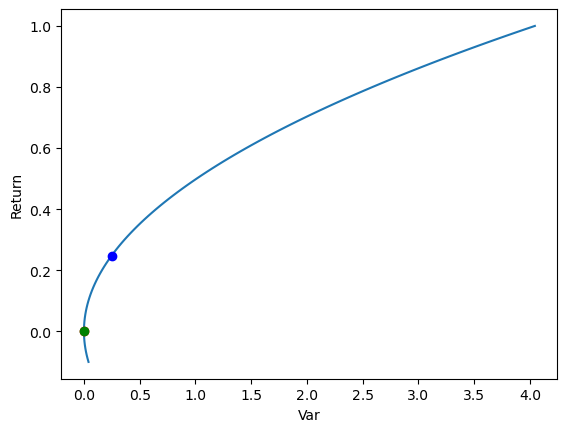

In [817]:
f = efficient_frontier(opt_mean.values, opt_vcv.values, risk_aversion=1, num_port=100)

ax = plt.gca()
ax.plot(f[0]['mu_std'], f[0]['mu_p'])
gmvp_weight = f[1]
gmvp_retr = f[2]
gmvp_vcv = f[3]

optimal_variance = f[-1]
optimal_mu = f[-2]

ax.plot(gmvp_vcv, gmvp_retr, 'ro')
ax.plot(optimal_variance, optimal_mu, 'bo')


res = optimal_portfolio(opt_mean.values, opt_vcv.values, f[1], 0.05)
ax.plot(res[-1], res[-2], 'go')
ax.set_xlabel('Var')
ax.set_ylabel('Return')

In [57]:
# ax = plt.gca()
# y2 = list(f[0]['mu_std']) # this is actually the squared root of the variance


# pmus = []
# pvols = []
# for i in range(len(random_weight.columns)):
#     res = ef_optimization(opt_vcv, random_weight.iloc[:, i], risk_free=False)

#     pmu = res.x @ opt_mean
#     pvol = res.x.T @ opt_vcv @ res.x
#     pmus.append(pmu)
#     pvols.append(pvol)
#     ax.plot(np.sqrt(pvol).T, pmu, 'ro')

# # ax.set_ylim(-0.01, 0.02)
# # ax.set_xlim(0, 0.05)
# ax.plot(y2, f['mu_p'])
# f['mu_std']

In [58]:
# ax = plt.gca()
# ax.plot(pvols, pmus, 'ro')
# ax.plot(y2, f['mu_p'])
# ax.set_xlim(0, 0.01)
# ax.set_ylim(-0.05, 0.05)

# Resampling function

In [299]:
def portfolio_resampling(Q, m, p0, risk_aversion=2, num_port=201):
    """
    
    :param Q: number of resampleing
    :param m: number of mu
    :param returns: returns
    :param nb_row: number of sample rows
    :param risk_aversion: risk aversion
    """
    ax = plt.gca()

    p0_ft, _, min_mu, min_cov, _, max_mu, max_cov = efficient_frontier(
        p0.mean(), p0.cov(), risk_aversion=risk_aversion, num_port=num_port)
    ax.plot(p0_ft.mu_std, p0_ft.mu_p, 'k--', label='p0')
    print('P0 data, min_mu / max_mu', min_mu, max_mu)

    mu_0 = p0.mean()
    cov_0 = p0.cov()

    opt_mus = []
    opt_covs = []
    a_res = [[] for i in range(m)]
    for i in range(Q):
        p1 = np.random.normal(loc=p0.mean().values, scale=p0.std().values, size=p0.shape)
        p1 = pd.DataFrame(p1)
        p1_ft, _, min_mu, min_cov, _, max_mu, max_cov = efficient_frontier(
            p1.mean(), p1.cov(), risk_aversion=risk_aversion, num_port=num_port)
        
        mu_1 = p1.mean()
        cov_1 = p1.cov()
        c = 0
        for mu in np.linspace(min_mu, max_mu, m):
            obj = lambda a: a.T @ cov_1 @ a
            cons1 = {
                'type': 'eq',
                'fun': lambda a: a.T @ (np.zeros(len(a)) + 1) - 1
            }
            cons2 = {
                'type': 'eq',
                'fun': lambda a: a.T @ mu_1 - mu
            }
            w0 = np.random.random(mu_1.shape)
            w0 /= w0.sum()
            bnds = [[None, None] for i in range(len(w0))]
            res = minimize(obj, x0=w0.reshape(-1), method='SLSQP', constraints=(cons1, cons2), bounds=bnds)
            r = res.x
            opt_mu = r.T @ mu_0
            opt_cov = r.T @ cov_0 @ r
            ax.plot(opt_cov, opt_mu, 'bo')
            opt_mus.append(opt_mu)
            opt_covs.append(opt_cov)
            a_res[c].append(r)
            c += 1

    mu_res = []
    cov_res = []
    ares = []
    for i in range(m):
        _a_res = np.asarray(a_res)[i].sum(axis=0)/Q
        mu_res.append(_a_res.T @ mu_0)
        cov_res.append(_a_res.T @ cov_0 @ _a_res)
        ares.append(_a_res)
        
    mu_res = np.array(mu_res)
    cov_res = np.array(cov_res)
    ares = np.array(ares)
    
    
    ax.plot(cov_res, mu_res, 'r-', label='resampled', ms=3)
    ax.legend()
    ax.set_xlim(-0.1, 1)
    ax.set_ylim(-0.1, 1)
    
    return p0_ft, mu_res, cov_res, ares, opt_mus, opt_covs

In [444]:
def get_ABCD(mu, cov):
    e = np.ones(len(mu))
    _A = e.T @  inv(cov) @ mu
    _B = mu.T @ inv(cov) @ mu
    _C = e.T @ inv(cov) @ e
    _D = _B*_C - _A**2
    return _A, _B, _C, _D

def get_MVP(mu, cov):
    _, _, _C, _ = get_ABCD(mu, cov)
    alpha_min = inv(cov) @ e / _C
    mu_min = alpha_min.T @ mu
    cov_min = alpha_min.T @ cov @ alpha_min
    return alpha_min, mu_min, cov_min

def get_SPEC(mu, cov):
    _A, _, _, _ = get_ABCD(mu, cov)
    alpha_spec = inv(cov) @ mu / _A
    mu_spec = alpha_spec.T @ mu
    cov_spec = alpha_spec.T @ cov @ alpha_spec
    return alpha_spec, mu_spec, cov_spec

def get_maxsharpe(mu, cov, risk_aversion=2):
    e = np.ones(len(mu))
    alpha_mvp, mu_mvp, cov_mvp = get_MVP(mu, cov)
    alpha_spec, mu_spec, cov_spec = get_SPEC(mu, cov)

    ratio_spec = (e.T @ inv(cov) @ mu) / risk_aversion
    ratio_mvp = 1 - ratio_spec

    optimal_weight = ratio_mvp * alpha_mvp + ratio_spec * alpha_spec
    optimal_mu = optimal_weight.T @ mu
    optimal_cov = optimal_weight.T @ cov @ optimal_weight
    return optimal_weight, optimal_mu, optimal_cov

def get_FT_func(mu, cov):
    _A, _, _C, _D = get_ABCD(mu, cov)
    return lambda x: (x - _A/_C)**2 * _C / _D + 1/_C

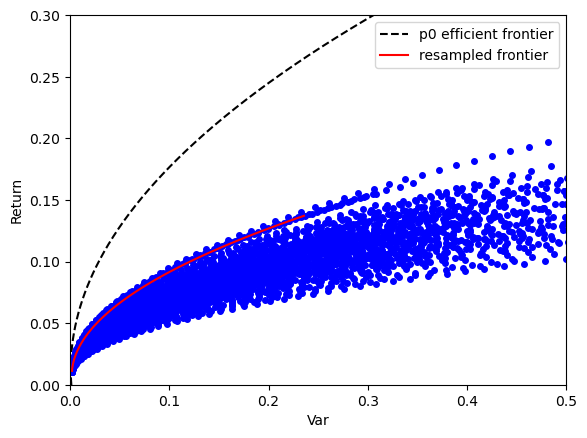

In [804]:
Q=100
m=50
p0=monthly_df.iloc[:-1]
risk_aversion=2

ax = plt.gca()

mu_0 = p0.mean()
cov_0 = p0.cov()
func = get_FT_func(mu_0, cov_0)
dummy_mu = np.linspace(-0.1, 0.8, 1001)
ax.plot(func(dummy_mu), dummy_mu, 'k--', label='p0 efficient frontier')

opt_mus = []
opt_covs = []
a_res = [[] for i in range(m)]
e = np.ones(len(mu_0))

for i in range(Q):
    p1 = np.random.normal(loc=p0.mean().values, scale=p0.std().values,
                          size=p0.shape
                         )
    p1 = pd.DataFrame(p1)
    mu_1 = p1.mean()
    cov_1 = p1.cov()

    _A, _B, _C, _D = get_ABCD(mu_1, cov_1)

    V1 = inv(cov_1)/_D @ (_B*e - _A*mu_1) 
    V2 = inv(cov_1)/_D @ (_C*mu_1 - _A*e)

    _, mu_mvp, _ = get_MVP(mu_1, cov_1)
    _, mu_ms, _ = get_maxsharpe(mu_1, cov_1, risk_aversion)
    
    c = 0
    for mu in np.linspace(mu_mvp, mu_ms, m):
        alpha_star = V1 + V2 * mu

        opt_mu = alpha_star.T @ mu_0
        opt_cov = alpha_star.T @ cov_0 @ alpha_star
        ax.plot(opt_cov, opt_mu, 'bo', ms=4)
        opt_mus.append(opt_mu)
        opt_covs.append(opt_cov)
        a_res[c].append(alpha_star)
        c += 1

mu_res = []
cov_res = []
ares = []
for i in range(m):
    _a_res = np.asarray(a_res)[i].sum(axis=0)/Q
    mu_res.append(_a_res.T @ mu_0)
    cov_res.append(_a_res.T @ cov_0 @ _a_res)
    ares.append(_a_res)

mu_res = np.array(mu_res)
cov_res = np.array(cov_res)
ares = np.array(ares)

ax.plot(cov_res.reshape(-1), mu_res.reshape(-1), 'r-', label='resampled frontier')
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 0.3)
ax.set_xlabel('Var')
ax.set_ylabel('Return')
ax.legend()

In [476]:
def portfolio_resampling_ABCD(Q, m, p0, risk_aversion=2, num_port=201, p1_num=None):
    """
    
    :param Q: number of resampleing
    :param m: number of mu
    :param returns: returns
    :param nb_row: number of sample rows
    :param risk_aversion: risk aversion
    """
#     ax = plt.gca()

    mu_0 = p0.mean()
    cov_0 = p0.cov()
#     func = get_FT_func(mu_0, cov_0)
#     dummy_mu = np.linspace(-0.1, 0.8, 1001)
#     ax.plot(func(dummy_mu), dummy_mu, 'k--', label='p0')

    opt_mus = []
    opt_covs = []
    a_res = [[] for i in range(m)]
    e = np.ones(len(mu_0))

    for i in range(Q):
        size = p0.shape
        if p1_num is not None:
            _, col = size
            size = (p1_num, col)
        p1 = np.random.normal(loc=p0.mean().values, scale=p0.std().values,
                              size=size)
        p1 = pd.DataFrame(p1)
        mu_1 = p1.mean()
        cov_1 = p1.cov()

        _A, _B, _C, _D = get_ABCD(mu_1, cov_1)

        V1 = inv(cov_1)/_D @ (_B*e - _A*mu_1) 
        V2 = inv(cov_1)/_D @ (_C*mu_1 - _A*e)

        _, mu_mvp, _ = get_MVP(mu_1, cov_1)
        _, mu_ms, _ = get_maxsharpe(mu_1, cov_1, risk_aversion)


        c = 0
        for mu in np.linspace(mu_mvp, mu_ms, m):
            alpha_star = V1 + V2 * mu

            opt_mu = alpha_star.T @ mu_0
            opt_cov = alpha_star.T @ cov_0 @ alpha_star
#             ax.plot(opt_cov, opt_mu, 'bo')
            opt_mus.append(opt_mu)
            opt_covs.append(opt_cov)
            a_res[c].append(alpha_star)
            c += 1

    mu_res = []
    cov_res = []
    ares = []
    for i in range(m):
        _a_res = np.asarray(a_res)[i].sum(axis=0)/Q
        mu_res.append(_a_res.T @ mu_0)
        cov_res.append(_a_res.T @ cov_0 @ _a_res)
        ares.append(_a_res)

    mu_res = np.array(mu_res)
    cov_res = np.array(cov_res)
    ares = np.array(ares)

#     ax.plot(cov_res.reshape(-1), mu_res.reshape(-1), 'r-')
    return mu_res, cov_res, ares, opt_mus, opt_covs

In [ ]:
def save_results(mu_res, cov_res, ares, filename):
    index_name = ...s
    mu_res = pd.DataFrame(mu_res, index=index_name)
    cov_res = pd.DataFrame(cov_res, index=index_name)
    ares = pd.DataFrame(ares, index=index_name)
    
    mu_res.to_csv(f'{filename}_mu.csv')
    cov_res.to_csv(f'{filename}_cov.csv')
    ares_res.to_csv(f'{filename}_ares.csv')

(-0.1, 0.5)

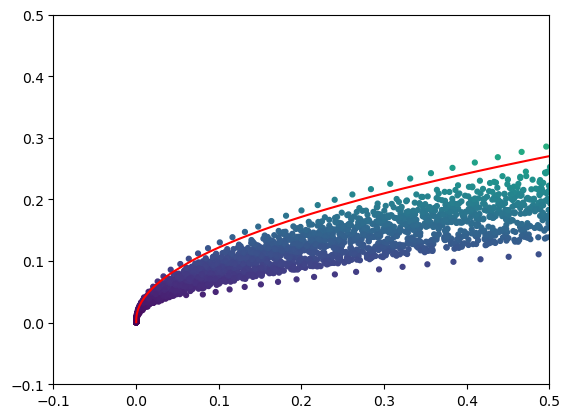

In [34]:
ax = plt.gca()

ax.plot(cov_res, mu_res, 'r-')
ax.scatter(opt_covs, opt_mus, c=np.asarray(opt_mus), s=12)
ax.set_xlim(-0.1, 0.5)
ax.set_ylim(-0.1, 0.5)

In [ ]:
# In sample MVP portfolios 

In [36]:
resampled_mu = pd.read_csv('mu_res.csv')
resampled_vcv = pd.read_csv('vcv_res')

In [37]:
#Average Annualized MVP Return
Expectation_MVP = resampled_mu.iloc[0]
Expectation_MVP = Expectation_MVP.drop(Expectation_MVP.index[0])
Expectation_MVP = Expectation_MVP.to_numpy()
A_Expectation_MVP = Expectation_MVP*252
A_Expectation_MVP

array([0.08458431])

In [ ]:
#Annualized volatility of the MVP
Variance_MVP = resampled_vcv.iloc[0]
Std_MVP = np.sqrt(Variance_MVP)
A_Std_MVP = Std_MVP * np.sqrt(252)
A_Std_MVP

In [ ]:
#MVP Weights
Weights_MVP = resampled_weight.iloc[0]
Weights_MVP = Weights_MVP.drop(Weights_MVP.index[0])
Weights_MVP = Weights_MVP.to_numpy()

#Minimum daily return of the MVP
Returns_daily_MVP = np.matmul(opt_simple,Weights_MVP)
Min_Returns_Daily_MVP = np.min(Returns_daily_MVP)
Min_Returns_Daily_MVP

In [ ]:
#Maximum daily return of the MVP
Returns_daily_MVP = np.matmul(opt_simple,Weights_MVP)
Min_Returns_Daily_MVP = np.max(Returns_daily_MVP)
Min_Returns_Daily_MVP

In [ ]:
#MVP performance
portfolio_values_MVP = [100]
for ret in Returns_daily_MVP:
    portfolio_values_MVP.append(portfolio_values_MVP[-1]*(1+ret))

plt.plot(portfolio_values_MVP)
plt.legend(['MVP Performance'])
plt.show()

In [ ]:
#Maximum Drawdown MVP
pd_portfolio_values_MVP = pd.Series(portfolio_values_MVP)
max_data_stock = pd_portfolio_values_MVP.rolling(window=len(pd_portfolio_values_MVP), min_periods=1).max()
dd_stock = pd_portfolio_values_MVP/max_data_stock - 1
MDD_stock = dd_stock.rolling(window=len(pd_portfolio_values_MVP), min_periods=1).min()
MDD_stock.min()

In [ ]:
#VaR and ES at 5% of the MVP
quantile_threshold = 0.05

quantile = np.quantile(Returns_daily_MVP, quantile_threshold)

expected_shortfall = np.mean(Returns_daily_MVP[Returns_daily_MVP<=quantile])

plt.hist(Returns_daily_MVP, 60)
VaR_95_MVP = np.percentile(Returns_daily_MVP, 5)
plt.axvline(x=VaR_95_MVP, color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=expected_shortfall, color='g', linestyle='dashed', linewidth=2)
plt.legend(['VaR 5%','ES 5%'])
plt.show()

In [ ]:
print("Value at Risk 5%:", VaR_95_MVP)
print("Expected Shortfall: ", expected_shortfall)

In [ ]:
# Equally weighted portfolio

In [ ]:
#Average Annualized MVP Return
Weights_EWP = [1/len(opt_mean)]*len(opt_mean)
Weights_EWP = np.array(Weights_EWP)
Weights_EWP_T = np.transpose(Weights_EWP)
Return_EWP = np.matmul(Weights_EWP_T,opt_mean)
A_Return_EWP = Return_EWP*252
A_Return_EWP

In [ ]:
#Annualized volatility of the EWP
Variance_EWP = np.matmul(Weights_EWP_T,np.matmul(opt_vcv,Weights_EWP))
Std_EWP = np.sqrt(Variance_EWP)
A_Std_EWP = Std_EWP * np.sqrt(252)
A_Std_EWP

In [ ]:
#Minimum daily return of the EWP
Returns_daily_EWP = np.matmul(opt_simple,Weights_EWP)
Min_Returns_Daily_EWP = np.min(Returns_daily_EWP)
Min_Returns_Daily_EWP

In [ ]:
#Maximum daily return of the MVP
Max_Returns_Daily_EWP = np.max(Returns_daily_EWP)
Max_Returns_Daily_EWP

In [ ]:
#EWP Performance
portfolio_values_EWP = [100]
for ret in Returns_daily_EWP:
    portfolio_values_EWP.append(portfolio_values_EWP[-1]*(1+ret))

plt.plot(portfolio_values_EWP)
plt.legend(['EWP Performance'])
plt.show()

In [ ]:
#Maximum Drawdown EWP
pd_portfolio_values_EWP = pd.Series(portfolio_values_EWP)
max_data_stock = pd_portfolio_values_EWP.rolling(window=len(pd_portfolio_values_EWP), min_periods=1).max()
dd_stock = pd_portfolio_values_EWP/max_data_stock - 1
MDD_stock = dd_stock.rolling(window=len(pd_portfolio_values_EWP), min_periods=1).min()
MDD_stock.min()

In [ ]:
#VaR and ES at 5% of the EWP
quantile_threshold = 0.05

quantile = np.quantile(Returns_daily_EWP, quantile_threshold)

expected_shortfall = np.mean(Returns_daily_EWP[Returns_daily_EWP<=quantile])

plt.hist(Returns_daily_EWP, 60)
VaR_95_EWP = np.percentile(Returns_daily_EWP, 5)
plt.axvline(x=VaR_95_EWP, color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=expected_shortfall, color='g', linestyle='dashed', linewidth=2)
plt.legend(['VaR 5%','ES 5%'])
plt.show()

In [ ]:
print("Value at Risk 5%:", VaR_95_EWP)
print("Expected Shortfall: ", expected_shortfall)

In [ ]:
# Value weighted portfolio 

In [ ]:
#Average Annualized VWP Return
market_cap['day'] = market_cap['Date'].dt.day
last_day_of_month = market_cap[market_cap['day'] == market_cap.groupby(market_cap['Date'].dt.month)['day'].transform('max')]
last_day_of_month = last_day_of_month.drop(columns=['Date', '#ERROR', '#ERROR.1', 'DENBURY - MARKET VALUE', 'EXCO RES - MARKET VALUE', 'day'])
opt_market = last_day_of_month.dropna(thresh=145).dropna(axis=1)
sum_list = opt_market.sum(axis=0)
Weights_VWP = [v / sum(sum_list) for v in sum_list]
Weights_VWP_T = np.transpose(Weights_VWP)
Return_VWP = np.matmul(Weights_VWP_T,opt_mean)
A_Return_VWP = Return_VWP*252
A_Return_VWP

In [ ]:
#Annualized volatility of the VWP
Variance_VWP = np.matmul(Weights_VWP_T,np.matmul(opt_vcv,Weights_VWP))
Std_VWP = np.sqrt(Variance_VWP)
A_Std_VWP = Std_VWP * np.sqrt(252)
A_Std_VWP

In [ ]:
#Minimum daily return of the VWP
Returns_daily_VWP = np.matmul(opt_simple,Weights_VWP)
Min_Returns_Daily_VWP = np.min(Returns_daily_VWP)
Min_Returns_Daily_VWP

In [ ]:
#Maximum daily return of the VWP
Returns_daily_VWP = np.matmul(opt_simple,Weights_VWP)
Max_Returns_Daily_VWP = np.max(Returns_daily_VWP)
Max_Returns_Daily_VWP

In [ ]:
#VWP Performance
portfolio_values_VWP = [100]
for ret in Returns_daily_VWP:
    portfolio_values_VWP.append(portfolio_values_VWP[-1]*(1+ret))

plt.plot(portfolio_values_VWP)
plt.legend(['VWP Performance'])
plt.show()

In [ ]:
#Maximum Drawdown VWP
pd_portfolio_values_VWP = pd.Series(portfolio_values_VWP)
max_data_stock = pd_portfolio_values_VWP.rolling(window=len(pd_portfolio_values_VWP), min_periods=1).max()
dd_stock = pd_portfolio_values_VWP/max_data_stock - 1
MDD_stock = dd_stock.rolling(window=len(pd_portfolio_values_VWP), min_periods=1).min()
MDD_stock.min()

In [ ]:
#VaR and ES at 5% of the VWP
quantile_threshold = 0.05

quantile = np.quantile(Returns_daily_VWP, quantile_threshold)

expected_shortfall = np.mean(Returns_daily_VWP[Returns_daily_VWP<=quantile])

plt.hist(Returns_daily_VWP, 60)
VaR_95_VWP = np.percentile(Returns_daily_VWP, 5)
plt.axvline(x=VaR_95_EWP, color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=expected_shortfall, color='g', linestyle='dashed', linewidth=2)
plt.legend(['VaR 5%','ES 5%'])
plt.show()

In [ ]:
print("Value at Risk 5%:", VaR_95_VWP)
print("Expected Shortfall: ", expected_shortfall)

In [ ]:
#Graph of the performance of the 3 portfolios

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(portfolio_values_MVP, label='MVP')
ax.plot(portfolio_values_EWP, label='EWP')
ax.plot(portfolio_values_VWP, label='VWP')

ax.set_title('Portfolio Values')
ax.legend()

plt.show()

# 1.5: 6-year moving window

## Structure the monthly data

In [557]:
# monthly return
r = simple_return.dropna(axis=1, thresh=6250)  # drop nan with a threshold
monthly_df = r.resample('M').agg(lambda x: (x + 1).prod() - 1)  # merge daily to monthly
monthly_df.head(5)

,CAMPBELL SOUP - TOT RETURN IND (~U$) (#T) - CAMPBELL SOUP - TOT RETURN IND (~U$) (#T),APARTMENT INV.& MAN.'A' - TOT RETURN IND (~U$) (#T) - APARTMENT INV.& MAN.'A' - TOT RETURN IND (~U$) (#T),WILLIAMS - TOT RETURN IND (~U$) (#T) - WILLIAMS - TOT RETURN IND (~U$) (#T),TNSC.'A' SBVTG. - TOT RETURN IND (~U$) (#T) - TNSC.'A' SBVTG. - TOT RETURN IND (~U$) (#T),XEROX HOLDINGS - TOT RETURN IND (~U$) (#T) - XEROX HOLDINGS - TOT RETURN IND (~U$) (#T),UNIVERSAL HEALTH SVS.'B' - TOT RETURN IND (~U$) (#T) - UNIVERSAL HEALTH SVS.'B' - TOT RETURN IND (~U$) (#T),RAYTHEON TECHNOLOGIES - TOT RETURN IND (~U$) (#T) - RAYTHEON TECHNOLOGIES - TOT RETURN IND (~U$) (#T),SCHNITZER STL.INDS. - TOT RETURN IND (~U$) (#T) - SCHNITZER STL.INDS. - TOT RETURN IND (~U$) (#T),NETAPP - TOT RETURN IND (~U$) (#T) - NETAPP - TOT RETURN IND (~U$) (#T),COPART - TOT RETURN IND (~U$) (#T) - COPART - TOT RETURN IND (~U$) (#T),...,STATE STREET - TOT RETURN IND (~U$) (#T) - STATE STREET - TOT RETURN IND (~U$) (#T),RAYONIER - TOT RETURN IND (~U$) (#T) - RAYONIER - TOT RETURN IND (~U$) (#T),S&P GLOBAL - TOT RETURN IND (~U$) (#T) - S&P GLOBAL - TOT RETURN IND (~U$) (#T),SYNOVUS FINANCIAL - TOT RETURN IND (~U$) (#T) - SYNOVUS FINANCIAL - TOT RETURN IND (~U$) (#T),FORTIS - TOT RETURN IND (~U$) (#T) - FORTIS - TOT RETURN IND (~U$) (#T),FREEHOLD ROYALTIES - TOT RETURN IND (~U$) (#T) - FREEHOLD ROYALTIES - TOT RETURN IND (~U$) (#T),CHEESECAKE FACTORY - TOT RETURN IND (~U$) (#T) - CHEESECAKE FACTORY - TOT RETURN IND (~U$) (#T),ROYAL CARIBBEAN GROUP - TOT RETURN IND (~U$) (#T) - ROYAL CARIBBEAN GROUP - TOT RETURN IND (~U$) (#T),ENTERPRISE PRDS.PTNS.LP. - TOT RETURN IND (~U$) (#T) - ENTERPRISE PRDS.PTNS.LP. - TOT RETURN IND (~U$) (#T),SUPERIOR PLUS - TOT RETURN IND (~U$) (#T) - SUPERIOR PLUS - TOT RETURN IND (~U$) (#T)
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-31,-0.143076,-0.001698,0.058115,-0.058479,0.050843,-0.137349,0.098276,-5.551115e-16,0.181886,-0.042463,...,0.019608,-0.042204,0.061350,0.036457,-0.007239,0.101595,-0.232846,0.075103,0.258427,0.040738
1999-02-28,-0.143808,0.070206,0.121210,0.022341,-0.109876,-0.092177,0.040220,-3.147608e-02,-0.207552,0.129028,...,0.072552,-0.069571,0.016024,-0.042713,0.003408,-0.110724,-0.098919,-0.164418,-0.123305,0.017227
1999-03-31,0.012441,-0.073479,0.071981,0.159461,-0.029328,0.064613,0.093340,-1.441489e-01,0.205354,0.185693,...,0.074364,-0.013874,-0.003998,-0.135419,0.024841,0.155864,0.158523,0.176211,-0.007735,0.044994
1999-04-30,0.007188,0.105182,0.196200,0.041253,0.100703,0.197982,0.069682,2.051753e-01,-0.006165,-0.126515,...,0.063830,0.138866,0.013761,0.079269,0.005934,0.285342,0.178958,-0.052118,0.154346,0.055428
1999-05-31,0.085889,0.064527,0.096562,-0.043654,-0.043607,-0.037393,-0.141110,6.924152e-02,-0.062737,0.006899,...,-0.128571,0.021916,-0.057378,-0.090397,-0.049073,-0.173093,-0.013410,0.060029,0.003489,-0.023169


In [665]:
# market cap

cols = []
for col in monthly_df.columns:
    col = col.split('-')
    for mkt_col in market_cap.columns:
        if mkt_col.startswith(col[0]):
            cols.append(mkt_col)
market_cap = market_cap.loc[:, market_cap.columns.isin(cols)] 
market_cap.index = r.index
market_cap = market_cap.resample('M').mean()

,CAMPBELL SOUP - MARKET VALUE,APARTMENT INV.& MAN.'A' - MARKET VALUE,WILLIAMS - MARKET VALUE,TNSC.'A' SBVTG. - MARKET VALUE,XEROX HOLDINGS - MARKET VALUE,UNIVERSAL HEALTH SVS.'B' - MARKET VALUE,RAYTHEON TECHNOLOGIES - MARKET VALUE,SCHNITZER STL.INDS. - MARKET VALUE,NETAPP - MARKET VALUE,COPART - MARKET VALUE,...,STATE STREET - MARKET VALUE,RAYONIER - MARKET VALUE,S&P GLOBAL - MARKET VALUE,SYNOVUS FINANCIAL - MARKET VALUE,FORTIS - MARKET VALUE,FREEHOLD ROYALTIES - MARKET VALUE,CHEESECAKE FACTORY - MARKET VALUE,ROYAL CARIBBEAN GROUP - MARKET VALUE,ENTERPRISE PRDS.PTNS.LP. - MARKET VALUE,SUPERIOR PLUS - MARKET VALUE
0,24451.78,1789.87,13341.14,219.44,38694.42,1577.52,24558.67,79.85,3064.89,431.17,...,11255.13,1279.59,10024.50,6415.22,320.51,76.57,589.30,6134.74,677.60,440.77
1,23979.42,1816.95,12913.36,226.14,38612.45,1604.13,24389.30,81.94,3075.57,387.89,...,11355.44,1269.14,10190.55,6398.51,318.99,77.81,563.84,5844.59,734.54,446.90
2,24618.50,1813.94,12779.68,220.85,39350.26,1611.73,25109.13,82.63,3067.03,377.90,...,11596.20,1272.63,10381.20,6532.16,323.23,78.54,561.36,6072.57,763.01,448.10
3,24285.07,1822.96,13180.72,220.27,40108.57,1609.83,25377.29,86.10,3135.37,389.55,...,11957.32,1281.33,10541.10,6665.82,329.04,80.01,556.39,6383.45,802.87,454.46
4,23951.63,1780.85,13180.72,219.16,39924.12,1564.21,25109.13,85.41,3161.00,386.22,...,11897.13,1267.40,10565.70,6348.39,336.15,83.38,535.27,6238.37,797.18,453.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6256,17153.50,1109.95,40583.80,816.21,2273.35,9030.80,145977.00,840.49,12727.44,28820.91,...,28434.19,4934.49,108471.80,5320.85,19476.54,1787.57,1648.53,12705.50,52104.89,1637.72
6257,17234.35,1079.62,40693.41,821.50,2287.36,9062.88,146506.30,867.93,12729.60,28620.86,...,28309.43,4952.07,107944.00,5357.21,19602.92,1799.17,1627.45,12478.39,52409.46,1648.34
6258,17081.62,1062.94,39852.99,811.76,2236.01,8941.62,145741.80,841.03,12542.05,28558.95,...,28195.68,4755.85,107383.60,5326.66,19302.92,1737.32,1621.79,12248.73,51691.52,1640.35
6259,16982.80,1090.24,40157.49,825.80,2254.68,9032.73,147491.10,850.54,12953.80,29163.84,...,28746.09,4893.49,110710.10,5447.39,19362.89,1747.62,1634.65,12708.06,52692.29,1673.06


## Portfolio using moving window

In [503]:
win_len = 72  # 6-year moving window
Q = 100  # number of Monte Carlo simulation
m = 2 # number of mean points durung the resampling, here is two for min mean and max mean.
p1_num = 200  # number of points of P1 sample, generated from the normal distribution of monthly data.

running = True  # loop condition
c = 0  # loop index

# --- results --- #
min_mu = []
max_mu = []

min_var = []
max_var = []

min_p = []
max_p = []
# --------------- #

while running:
    print(f'Progress: {c}/217 ...')
    
    # generate moving window
    start = c
    stop = c + win_len-1
    mov = monthly_df.iloc[slice(start, stop), :]
    
    # resampling
    mu_res, cov_res, ares, _, _ = portfolio_resampling_ABCD(Q=Q, m=m, p0=mov, p1_num=p1_num)
    min_mu.append(mu_res[0])
    max_mu.append(mu_res[-1])
    
    min_var.append(cov_res[0])
    max_var.append(cov_res[-1])
    
    min_p.append(ares[0])
    max_p.append(ares[-1])
    
    c += 1
    if stop == len(monthly_df):
        running = False


# Convert to DataFrame        
min_mu = pd.DataFrame(min_mu, index=monthly_df[monthly_df.index > '2005'].index)
max_mu = pd.DataFrame(max_mu, index=monthly_df[monthly_df.index > '2005'].index)

min_var = pd.DataFrame(min_var, index=monthly_df[monthly_df.index > '2005'].index)
max_var = pd.DataFrame(max_var, index=monthly_df[monthly_df.index > '2005'].index)

min_p = pd.DataFrame(min_p, index=monthly_df[monthly_df.index > '2005'].index)
max_p = pd.DataFrame(max_p, index=monthly_df[monthly_df.index > '2005'].index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217


## Performance of the moving window methodology

In [558]:
# mean
res = [[], []]
for i in range(18*12):
    ret = min_p.iloc[i].values.T @ monthly_df.iloc[i+72]
    res[0].append(ret)
    ret = max_p.iloc[i].values.T @ monthly_df.iloc[i+72]
    res[1].append(ret)

# convert to DataFrame
port_min_mu = pd.DataFrame(res[0], index=monthly_df[monthly_df.index > '2005'].index,
             columns=['performance_min_mu'])
port_min_mu.to_csv('monving_window_performance_min_mu_strategy.csv')
port_max_mu = pd.DataFrame(res[1], index=monthly_df[monthly_df.index > '2005'].index,
             columns=['performance_max_mu'])
port_max_mu.to_csv('monving_window_performance_max_mu_strategy.csv')


In [750]:
from collections import namedtuple
Char = namedtuple('Char',
    'annualized_average_return annualized_volatility minimal maximal max_drawdown VaR ES')
def cal_char(a):
    return Char(
        annualized_average_return=(a.mean()*12)[0],
        annualized_volatility=(np.sqrt(a.cov()*12)).values[0][0],
        minimal=a.min()[0],
        maximal=a.max()[0],
        max_drawdown=(a.min()/ a.max() - 1)[0],
        VaR=a.quantile(0.05)[0],
        ES=a[a < a.quantile(0.05)].mean()[0]
        )

In [753]:
# characteristics
port_min_mu_char = cal_char(port_min_mu)
port_max_mu_char = cal_char(port_max_mu)
dfs = [pd.DataFrame(port_min_mu_char._asdict(), index=['moving_window_min_mu']), 
       pd.DataFrame(port_max_mu_char._asdict(), index=['moving_window_max_mu'])]
dfs = pd.concat(dfs)
dfs

,annualized_average_return,annualized_volatility,minimal,maximal,max_drawdown,VaR,ES
moving_window_min_mu,0.113895,0.147062,-0.187095,0.133817,-2.398144,-0.064106,-0.100533
moving_window_max_mu,-0.153996,6.242105,-5.492555,9.354066,-1.587184,-2.772540,-4.709701


## Comparison

In [698]:
# other weights
equal_weights = np.ones(len(monthly_df.columns)) / len(monthly_df.columns)
mkt_weights = market_cap[market_cap.index > '2005'].div(
    market_cap[market_cap.index > '2005'].sum(axis=1), axis=0)

In [755]:
# equal
port_equal = equal_weights @ monthly_df[market_cap.index > '2005'].T
port_equal = port_equal.to_frame('eql')

# mkt
rs = []
for i in range(len(mkt_weights)):
    w = mkt_weights.iloc[i].values.reshape(1, -1) @ monthly_df[market_cap.index > '2005'].iloc[i].T.values
    rs.append(w[0])
port_mkt = pd.DataFrame(rs, index=monthly_df[market_cap.index > '2005'].index, columns=['mkt'])

# characteristics
port_equal_char = cal_char(port_equal)
port_mkt_char = cal_char(port_mkt)
dfs_others = [pd.DataFrame(port_equal_char._asdict(), index=['equal']), 
       pd.DataFrame(port_mkt_char._asdict(), index=['value'])]
dfs_others = pd.concat(dfs_others)
final_char = pd.concat([dfs, dfs_others])
final_char

,annualized_average_return,annualized_volatility,minimal,maximal,max_drawdown,VaR,ES
moving_window_min_mu,0.113895,0.147062,-0.187095,0.133817,-2.398144,-0.064106,-0.100533
moving_window_max_mu,-0.153996,6.242105,-5.492555,9.354066,-1.587184,-2.772540,-4.709701
equal,0.132712,0.185005,-0.214585,0.220196,-1.974518,-0.081617,-0.120992
value,0.128097,0.144637,-0.155107,0.119955,-2.293047,-0.062955,-0.091669


# 1.6 Positive constraint, $P_{oss}^{(+)}$

In [767]:
def portfolio_resampling_pos_constraint(Q, m, p0, risk_aversion=2, p1_num=200):
    """
    
    :param Q: number of resampleing
    :param m: number of mu
    :param returns: returns
    :param nb_row: number of sample rows
    :param risk_aversion: risk aversion
    """
    mu_0 = p0.mean()
    cov_0 = p0.cov()

    opt_mus = []
    opt_covs = []
    a_res = [[] for i in range(m)]
    for i in range(Q):
        size = p0.shape
        if p1_num is not None:
            _, col = size
            size = (p1_num, col)
        p1 = np.random.normal(loc=p0.mean().values, scale=p0.std().values, size=size)
        p1 = pd.DataFrame(p1)
        p1_ft, _, min_mu, min_cov, _, max_mu, max_cov = efficient_frontier(
            p1.mean(), p1.cov(), risk_aversion=risk_aversion, num_port=201)
        
        mu_1 = p1.mean()
        cov_1 = p1.cov()
        c = 0
        for mu in np.linspace(min_mu, max_mu, m):
            obj = lambda a: a.T @ cov_1 @ a
            cons1 = {
                'type': 'eq',
                'fun': lambda a: a.T @ (np.zeros(len(a)) + 1) - 1
            }
            cons2 = {
                'type': 'eq',
                'fun': lambda a: a.T @ mu_1 - mu
            }
            w0 = np.random.random(mu_1.shape)
            w0 /= w0.sum()
            bnds = [[0, 1] for i in range(len(w0))]
            res = minimize(obj, x0=w0.reshape(-1), method='SLSQP', constraints=(cons1, cons2), bounds=bnds)
            r = res.x
            opt_mu = r.T @ mu_0
            opt_cov = r.T @ cov_0 @ r
            opt_mus.append(opt_mu)
            opt_covs.append(opt_cov)
            a_res[c].append(r)
            c += 1

    mu_res = []
    cov_res = []
    ares = []
    for i in range(m):
        _a_res = np.asarray(a_res)[i].sum(axis=0)/Q
        mu_res.append(_a_res.T @ mu_0)
        cov_res.append(_a_res.T @ cov_0 @ _a_res)
        ares.append(_a_res)
        
    mu_res = np.array(mu_res)
    cov_res = np.array(cov_res)
    ares = np.array(ares)
    
    
    return mu_res, cov_res, ares, opt_mus, opt_covs

In [ ]:
win_len = 72  # 6-year moving window
Q = 10  # number of Monte Carlo simulation
m = 2 # number of mean points durung the resampling, here is two for min mean and max mean.
p1_num = 200  # number of points of P1 sample, generated from the normal distribution of monthly data.

running = True  # loop condition
c = 0  # loop index

# --- results --- #
min_mu = []
max_mu = []

min_var = []
max_var = []

min_p = []
max_p = []
# --------------- #

while running:
    timestart = time.time()
    
    # generate moving window
    start = c
    stop = c + win_len-1
    mov = monthly_df.iloc[slice(start, stop), :]
    
    # resampling
    mu_res, cov_res, ares, _, _ = portfolio_resampling_pos_constraint(Q=Q, m=m, p0=monthly_df)
    min_mu.append(mu_res[0])
    max_mu.append(mu_res[-1])
    
    min_var.append(cov_res[0])
    max_var.append(cov_res[-1])
    
    min_p.append(ares[0])
    max_p.append(ares[-1])
    
    timestop = time.time()
    
    print(f'Progress: {c}/217, {timestop-timestart}s')
    c += 1
    if stop == len(monthly_df):
        running = False

# # Convert to DataFrame        
# min_mu = pd.DataFrame(min_mu, index=monthly_df[monthly_df.index > '2005'].index)
# max_mu = pd.DataFrame(max_mu, index=monthly_df[monthly_df.index > '2005'].index)

# min_var = pd.DataFrame(min_var, index=monthly_df[monthly_df.index > '2005'].index)
# max_var = pd.DataFrame(max_var, index=monthly_df[monthly_df.index > '2005'].index)

min_p = pd.DataFrame(min_p, index=monthly_df[monthly_df.index > '2005'].index,
                     columns=[i.split('-')[0] for i in monthly_df.columns])
max_p = pd.DataFrame(max_p, index=monthly_df[monthly_df.index > '2005'].index,
                     columns=[i.split('-')[0] for i in monthly_df.columns])


In [791]:
# save data
min_p.to_csv('1.6_long_only_port_min_mu.csv')
max_p.to_csv('1.6_long_only_port_max_mu.csv')

In [795]:
# mean
res = [[], []]
for i in range(18*12):
    ret = min_p.iloc[i].values.T @ monthly_df.iloc[i+72]
    res[0].append(ret)
    ret = max_p.iloc[i].values.T @ monthly_df.iloc[i+72]
    res[1].append(ret)

# convert/save to DataFrame
port_min_mu = pd.DataFrame(res[0], index=monthly_df[monthly_df.index > '2005'].index,
             columns=['performance_min_mu'])
port_min_mu.to_csv('1.6_monving_window_performance_min_mu_strategy.csv')
port_max_mu = pd.DataFrame(res[1], index=monthly_df[monthly_df.index > '2005'].index,
             columns=['performance_max_mu'])
port_max_mu.to_csv('1.6_monving_window_performance_max_mu_strategy.csv')

In [800]:
port_min_mu_char = cal_char(port_min_mu)
port_max_mu_char = cal_char(port_max_mu)
poos_pos_df = [pd.DataFrame(port_min_mu_char._asdict(), index=['Poos_pos_min_mu']), 
                 pd.DataFrame(port_max_mu_char._asdict(), index=['Poos_pos_max_mu'])]

In [802]:
df = pd.concat([final_char, *poos_pos_df])  # save to file, named '1.6_portfolio_characteristics_comparison.csv'

,annualized_average_return,annualized_volatility,minimal,maximal,max_drawdown,VaR,ES
moving_window_min_mu,0.113895,0.147062,-0.187095,0.133817,-2.398144,-0.064106,-0.100533
moving_window_max_mu,-0.153996,6.242105,-5.492555,9.354066,-1.587184,-2.772540,-4.709701
equal,0.132712,0.185005,-0.214585,0.220196,-1.974518,-0.081617,-0.120992
value,0.128097,0.144637,-0.155107,0.119955,-2.293047,-0.062955,-0.091669
Poos_pos_min_mu,0.123326,0.158460,-0.186231,0.161655,-2.152026,-0.072498,-0.104905
Poos_pos_max_mu,0.292242,0.458448,-0.401561,0.542775,-1.739829,-0.142510,-0.192738


* `moving_window_min_mu`: out-of-sample portfolio $P_{oos}$ with minimal variance strategy
* `moving_window_max_mu`: out-of-sample portfolio $P_{oos}$ with maximal variance strategy
* `equal`: equally weighted
* `value`: value weighted
* `Poos_pos_min_mu`: out-of-sample long-only portfolio $P_{oos}$ with minimal variance strategy
* `Poos_pos_max_mu`: out-of-sample long-only portfolio $P_{oos}$ with maximal variance strategy